In [1]:
import matplotlib.pyplot as plt
import time

# Tensorflow / Keras
from keras import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.optimizers import Adam

from keras.optimizers import SGD

import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Masking
from sklearn.metrics import accuracy_score
# file processing
import os

## Load Data

In [2]:
def slice_per_step(a, step=16):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    pad_count = step - (a.shape[0] % step)
    print(a.shape, end=' ')
    if pad_count!=step : 
        print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)

    # reshape into per step
    a = np.reshape(a, (-1, step, a.shape[1]))
    print('to',a.shape)

    return a

In [4]:
# Load Data
PATH = "test_input" 
file_dir = os.listdir(PATH) 
X_data = list()
y_data = list()
max_len = -1

for file in file_dir:
    loaded_file = np.load(PATH + "/" + file)
    # if the file name ends with "X.npy"
    if file.endswith("ans.npy"):
        y_data.extend(slice_per_step(loaded_file))
    else:
        X_data.extend(slice_per_step(loaded_file))

X_data = np.array(X_data)
y_data = np.array(y_data)

#print("X_data shape: ", X_data.shape, X_data.dtype)
#print("y_data shape: ", y_data.shape, y_data.dtype)

(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1568, 52) to (98, 16, 52)
(1568, 42) to (98, 16, 42)
(1561, 52) pad by 7 to (98, 16, 52)
(1561, 42) pad by 7 to (98, 16, 42)
(1561, 52) pad by 7 to (98, 16, 52)
(1561, 42) pad by 7 to (98, 16, 42)
(1561, 52) pad by 7 to (98, 16, 52)
(1561, 42) pad by 7 to (98, 16, 42)
(1561, 52) pad by 7 to (98, 16, 52)
(1561, 42) pad by 7 to (98, 16, 42)
(1561, 52) pad by 7 to (98, 16, 52)
(1561, 42) pad by 7 to (98, 

## Parameter

In [16]:
n_step = len(X_data)
piece_length = 16

n_hidden = 200 # Hidden layer
n_feature = 42 # num of input features (12*3 + 1 + 1 + 2 + 1 + 1)
n_pitch = 52 # one-hot of pitch (B0 ~ D5)  

# Training
epoch = 200
learning_rate = 0.001
training_iters = n_step * epoch  # Loop epoch times on the dataset
batch_size = 64

print("Minimum data:", (n_step/batch_size)*epoch)

Minimum data: 7350.0


## Split Data

In [6]:
# Data Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42, shuffle=True)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

print("y_train shape: ", y_data.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (2116, 16, 42)
X_test shape:  (236, 16, 42)
y_train shape:  (2352, 16, 52)
y_test shape:  (236, 16, 52)


## Additional Functions

In [7]:
def batch_generator(X, y):
    """ Input Output batch generator.
        
        return: 
        - 3d-array with shape of (batch_size, piece_length, n_feature)
        - 3d-array with shape of (batch_size, piece_length, n_feature)
    """
    while True:
        for i in range(0, n_step, batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

## Build Neural Network

In [17]:
print("Creating model")
input = Input(shape=(piece_length, n_feature,), name="Input_step_of_3chromagram_speed_nInstrument_timeSig_beatPos_barPos")  

masked_input = Masking(mask_value=-1, name="Mask_layer_for_padded_data")(input) # Ignore Padded Data

LSTM_forward = LSTM(units=n_hidden,
                input_shape=(piece_length, n_feature, ),
                return_sequences=True,
                name="LSTM_forwards")(masked_input)

time_dist = TimeDistributed(Dense(n_pitch, activation="tanh"), name="Dense_layer_for_each_memory_cell")(LSTM_forward)

softmax = Activation('softmax', name="Softmax")(time_dist)

model = Model(inputs=input, outputs=softmax)

model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['categorical_accuracy'])
print(model.summary())

Creating model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_step_of_3chromagram_s  [(None, 16, 42)]         0         
 peed_nInstrument_timeSig_be                                     
 atPos_barPos (InputLayer)                                       
                                                                 
 Mask_layer_for_padded_data   (None, 16, 42)           0         
 (Masking)                                                       
                                                                 
 LSTM_forwards (LSTM)        (None, 16, 200)           194400    
                                                                 
 Dense_layer_for_each_memory  (None, 16, 52)           10452     
 _cell (TimeDistributed)                                         
                                                                 
 Softmax (Activation)        (None, 16, 52) 

## Train Model

In [18]:
# train model
model.fit_generator(batch_generator(X_train, y_train),
                    steps_per_epoch=(n_step/batch_size),
                    epochs=epoch,
                    verbose=1)

Epoch 1/200


C:\Users\User\AppData\Local\Temp\ipykernel_3232\3383937935.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(batch_generator(X_train, y_train),


36/36 [==============================] - 3s 16ms/step - loss: 3.4277 - categorical_accuracy: 0.2089
Epoch 2/200
36/36 [==============================] - 1s 15ms/step - loss: 2.8970 - categorical_accuracy: 0.4396
Epoch 3/200
36/36 [==============================] - 1s 16ms/step - loss: 2.6725 - categorical_accuracy: 0.5576
Epoch 4/200
36/36 [==============================] - 1s 14ms/step - loss: 2.5602 - categorical_accuracy: 0.6049
Epoch 5/200
36/36 [==============================] - 1s 15ms/step - loss: 2.4863 - categorical_accuracy: 0.6334
Epoch 6/200
36/36 [==============================] - 1s 14ms/step - loss: 2.4363 - categorical_accuracy: 0.6506
Epoch 7/200
36/36 [==============================] - 1s 14ms/step - loss: 2.3980 - categorical_accuracy: 0.6665
Epoch 8/200
36/36 [==============================] - 1s 14ms/step - loss: 2.3689 - categorical_accuracy: 0.6745
Epoch 9/200
36/36 [==============================] - 1s 14ms/step - loss: 2.3449 - categorical_accuracy: 0.6834
Epoc

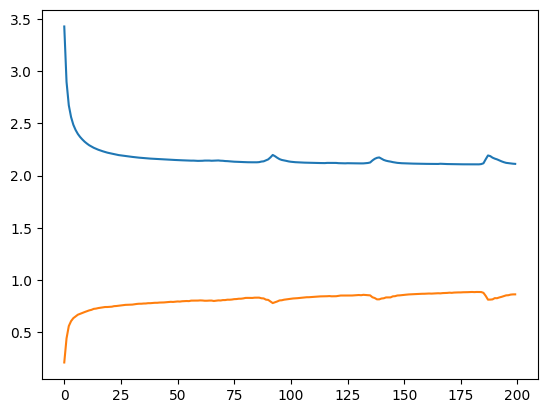

In [19]:
# save model
#model.save("lstm")
# plot
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['categorical_accuracy'])

## Predict

In [15]:
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=2)
#print(pred_test)

8/8 [==============================] - 0s 4ms/step
[[16 16 16 ... 20 20 20]
 [18 18 18 ... 14 14 14]
 [17 17 17 ... 21 21 21]
 ...
 [12 12 12 ... 14 14 14]
 [11 11 23 ... 18 18 18]
 [21 21 21 ... 28 16 16]]


## Midi output

In [ ]:
import midi_np_translation.output2midi as output2midi
PATH = "test_input"
# load np file
test_file = np.load(PATH + "/" + "4on6.mid.npy")
test_file_truth = np.load(PATH + "/" + "4on6.mid.ans.npy")
output2midi.output_to_midi(bass_ndarr=test_file_truth, output_path="4on6_truth.mid")
test_result = model.predict(slice_per_step(test_file))
test_result = np.argmax(test_result, axis=2)
output2midi.output_to_midi(bass_ndarr=test_result, output_path="4on6_result.mid")